In [110]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
import matplotlib.animation as animation
import os


warnings.filterwarnings('ignore')


In [111]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [112]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [113]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [114]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    return freq

In [115]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [116]:

def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0


    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

        

In [117]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [118]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [119]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt):
    global g
    
    init_system()
    
    for t in range(sim_time):
        if(int(t%dt)==0): 
            grow(t,mbt)
        break_cluster(t,max_node)
        graph_snap(t,sim_time)
    
    module_counter()
    
    return g

### Data BUD4

In [121]:
cd /Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2/

/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/BUD4_Repeat_2/counts_2


In [122]:
files=sorted(os.listdir())
counts=[]
count_data=pd.DataFrame()

for f in files:
    if('BUD4' in f):
        df=pd.read_csv(f)['cell_counts']
        count_data[f[7:f.index('.c')]]=df

CPU times: user 1.15 s, sys: 108 ms, total: 1.26 s
Wall time: 734 ms


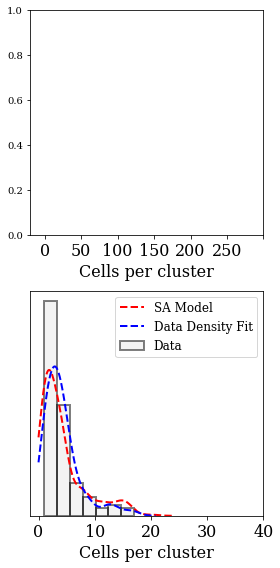

In [125]:
%%time
%matplotlib inline

kn=[8,5]
gr=[3,3]
be=['0','7.5']
xlim=[250,30]
bins=[50,50]
mbt=[100,32]
plt.rc('font',family='serif')
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(4,8))
t=['BUD4OFF','BUD4ON']


i=1
sim_time=int(gr[i]*10)
kissing_no=kn[i]
mean_breaking_time=mbt[i]
doubling_time=gr[i]

g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)

sns.kdeplot(np.array(count_freq(g)),color=(1,0.0,0.0,1),linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)
ax[i].hist(count_data[be[i]],7,color=(0.1,0.1,0.1,0.05),cumulative=False,density=True,edgecolor=(0,0,0,0.5),linewidth=2)
sns.kdeplot(count_data[be[i]],color=(0,0.0,1.0,1),linestyle='--',linewidth=2,clip=(0,xlim[i]),ax=ax[i],cumulative=False)

ax[i].set_yticks([])
ax[i].set_ylabel('')
ax[0].set_xlabel('')
ax[i].legend(['SA Model','Data Density Fit','Data'],fontsize=12)
ax[0].set_xlabel('')
ax[0].set_xlim(-10,150)
ax[1].set_xlim(-1.5,40)
ax[0].set_xticklabels([-50,0,50,100,150,200,250],fontsize=16)
ax[1].set_xticklabels([-20,0,10,20,30,40,50],fontsize=16)
ax[0].set_xlabel('Cells per cluster',fontsize=16)
ax[1].set_xlabel('Cells per cluster',fontsize=16)

fig.tight_layout()

fig.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/Model2A_ON.jpg',dpi=600)

#### Mean breaking time is trying to tell us something deep and remarkable about our world and it deserves my attention. 

In [114]:
ks_2samp_pval=[]
for k in range(100):
    sim_time=int(3*10)
    kissing_no=8
    mean_breaking_time=100
    doubling_time=3
    g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)
    stat,pval=stats.ks_2samp(count_data[be[0]],count_freq(g))
    ks_2samp_pval.append(pval)

<AxesSubplot:ylabel='Density'>

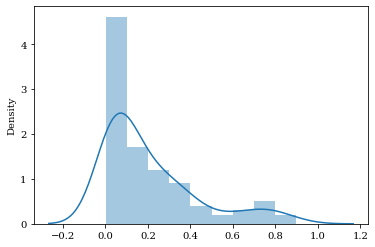

In [115]:
sns.distplot(ks_2samp_pval)

In [82]:
sim_time=int(3*10)
kissing_no=5
mean_breaking_time=100
doubling_time=3
g=clust_form_and_break(sim_time,kissing_no,mean_breaking_time,doubling_time)
stats.ks_2samp(count_data[be[1]],count_freq(g))

KstestResult(statistic=0.24545454545454545, pvalue=4.1851656993508983e-05)

## Cluster Statistics Experiment vs Simulations

In [39]:
f=pd.read_csv('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Data/ePN002/stats_bud4_on_off.csv')

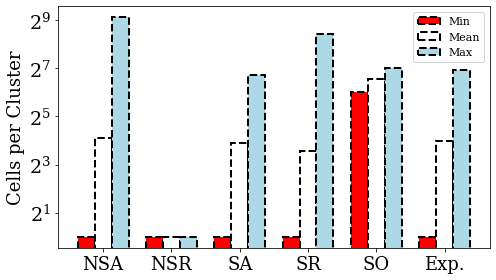

In [40]:
ind = np.arange(0,6)*1.33  
width = .33

plt.rc('font',family='serif')
plt.figure(figsize=(7,4))
plt.bar(ind-width, f['Min'][0:6], width,label='Min',color='red',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind, f['Mean'][0:6], width,label='Mean',color='white',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind+width, f['Max'][0:6], width,label='Max',color='lightblue',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(ind,['NSA','NSR','SA','SR','SO','Exp.'],fontsize=18)
plt.yticks(fontsize=19)
plt.legend(fontsize=11)
plt.ylabel('Cells per Cluster',fontsize=18)
plt.yscale('log',base=2)
plt.tight_layout()

# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/ON_Comparison.jpg',dpi=600)


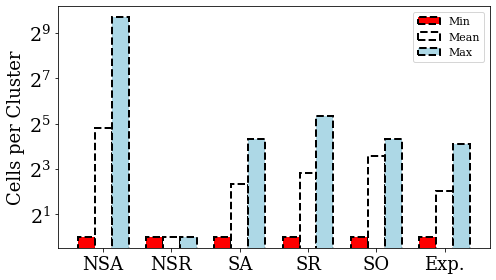

In [41]:
ind = np.arange(0,6)*1.33  
width = .33

plt.rc('font',family='serif')
plt.figure(figsize=(7,4))
plt.bar(ind-width, f['Min'][6:12], width,label='Min',color='red',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind, f['Mean'][6:12], width,label='Mean',color='white',edgecolor='black',linewidth=2,linestyle='--')
plt.bar(ind+width, f['Max'][6:12], width,label='Max',color='lightblue',edgecolor='black',linewidth=2,linestyle='--')
plt.xticks(ind,['NSA','NSR','SA','SR','SO','Exp.'],fontsize=18)
plt.yticks(fontsize=19)
plt.legend(fontsize=11)
plt.ylabel('Cells per Cluster',fontsize=18)
plt.yscale('log',base=2)
plt.tight_layout()

# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/OFF_Comparison.jpg',dpi=600)